Lab7
By: Hayden Donofrio, et al.


In [34]:
#lets prepare the data. Reading from the train.txt file
#make sure to concatenate the test.txt and train.txt files together so we can do our own split
import nltk
from nltk.corpus import stopwords 
nltk.download('punkt')
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
X = []
y = []
data = []
stop_words = set(stopwords.words('english')) 
with open("test.ft.txt", "r") as f:
    for line in f:
        if line.split()[0] == "__label__2": #positive label
            y.append(np.array([1,0]))
        else:
            y.append(np.array([0,1]))
        data.append(line[1:])

NUM_TOP_WORDS = None
MAX_ART_LEN = 1000 
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)

word_index = tokenizer.word_index
word_index = {w:i for w,i in word_index.items() if not w in stop_words} #added this line of code
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

[nltk_data] Downloading package punkt to /Users/munch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Found 291283 unique tokens. Distilled to 291283 top words.


In [4]:
#X[0:100]

In [35]:
#lets see how evenly spread our ys are to help select a metric
# since they are one hot encoded we can just some along each column
y = np.array(y)

In [36]:
print("positive class #: ", sum(y[:,0]), " Negative class #: ", sum(y[:,1]))

positive class #:  200000  Negative class #:  200000


We can see that the classes are evenly split! We are not specifically targeting a positive class over a negative class therefore accuracy would not be a bad metric for this dataset!

We have a very large amount of data for each class. An 80/20 split should be sufficent since we have over 100,000 items for each class

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y, test_size=0.2)

In [38]:
#now lets load the pre-trained keras embedding
!ls "glove/" 
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove/glove.6B.300d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    print(values[1:])
    break
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

glove.6B.300d.txt
['0.04656', '0.21318', '-0.0074364', '-0.45854', '-0.035639', '0.23643', '-0.28836', '0.21521', '-0.13486', '-1.6413', '-0.26091', '0.032434', '0.056621', '-0.043296', '-0.021672', '0.22476', '-0.075129', '-0.067018', '-0.14247', '0.038825', '-0.18951', '0.29977', '0.39305', '0.17887', '-0.17343', '-0.21178', '0.23617', '-0.063681', '-0.42318', '-0.11661', '0.093754', '0.17296', '-0.33073', '0.49112', '-0.68995', '-0.092462', '0.24742', '-0.17991', '0.097908', '0.083118', '0.15299', '-0.27276', '-0.038934', '0.54453', '0.53737', '0.29105', '-0.0073514', '0.04788', '-0.4076', '-0.026759', '0.17919', '0.010977', '-0.10963', '-0.26395', '0.07399', '0.26236', '-0.1508', '0.34623', '0.25758', '0.11971', '-0.037135', '-0.071593', '0.43898', '-0.040764', '0.016425', '-0.4464', '0.17197', '0.046246', '0.058639', '0.041499', '0.53948', '0.52495', '0.11361', '-0.048315', '-0.36385', '0.18704', '0.092761', '-0.11129', '-0.42085', '0.13992', '-0.39338', '-0.067945', '0.12188', '0

In [40]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(300,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(2, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 300)         87385200  
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 602       
Total params: 88,107,002
Trainable params: 721,802
Non-trainable params: 87,385,200
_________________________________________________________________
None


In [42]:
#change this [0:50] to a larger size, I made it smaller so we can focus on graphing history and then moving it up later
history = rnn.fit(X_train[0:50], y_train_ohe[0:50], validation_data=(X_test[0:5000], y_test_ohe[0:5000]), epochs=3, batch_size=64)

Train on 50 samples, validate on 5000 samples
Epoch 1/3
50/50 [==============================] - 247s 5s/step - loss: 0.6931 - accuracy: 0.4200 - val_loss: 0.6931 - val_accuracy: 0.5076
Epoch 2/3
50/50 [==============================] - 243s 5s/step - loss: 0.6896 - accuracy: 0.5800 - val_loss: 0.6992 - val_accuracy: 0.5076
Epoch 3/3
50/50 [==============================] - 243s 5s/step - loss: 0.6834 - accuracy: 0.5800 - val_loss: 0.7003 - val_accuracy: 0.5076


In [43]:
#this is the gru
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU

gru = Sequential()
gru.add(embedding_layer)
gru.add(GRU(300,activation='tanh',recurrent_activation='sigmoid',dropout=0.2, recurrent_dropout=0.2))
gru.add(Dense(2, activation='sigmoid'))
gru.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(gru.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 300)         87385200  
_________________________________________________________________
gru_2 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 602       
Total params: 87,926,702
Trainable params: 541,502
Non-trainable params: 87,385,200
_________________________________________________________________
None


In [44]:
gru_history = rnn.fit(X_train[0:50], y_train_ohe[0:50], validation_data=(X_test[0:5000], y_test_ohe[0:5000]), epochs=3, batch_size=64)

Train on 50 samples, validate on 5000 samples
Epoch 1/3
50/50 [==============================] - 244s 5s/step - loss: 0.6802 - accuracy: 0.5800 - val_loss: 1.2517 - val_accuracy: 0.5076
Epoch 2/3
50/50 [==============================] - 243s 5s/step - loss: 1.0811 - accuracy: 0.5800 - val_loss: 0.6930 - val_accuracy: 0.5076
Epoch 3/3
50/50 [==============================] - 242s 5s/step - loss: 0.6907 - accuracy: 0.5800 - val_loss: 0.6931 - val_accuracy: 0.5076


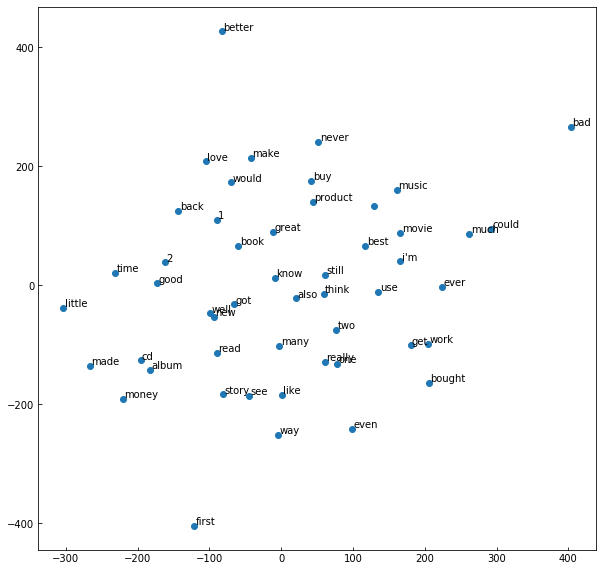

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings(embeddings,names):
    model = TSNE(n_components=3, method='exact',random_state=0)
    vectors = model.fit_transform(embeddings)
    x,y = vectors[:,0],vectors[:,1]
    fig,ax = plt.subplots(figsize=(10,10))
    ax.scatter(x,y)
    ax.tick_params(direction='in')
    for i, n in enumerate(names):
        ax.annotate(n,xy=(x[i], y[i]),xytext=(x[i]+2, y[i]+2))
        
words_to_plot = 50
names_sub = list(word_index.keys())[1:words_to_plot]
embedding_sub = embedding_matrix[1:words_to_plot+1,:]

plot_embeddings(embedding_sub, names_sub)